> Code to accompany **Chapter 10: Defending Against Adversarial Inputs**

# Training a Model With Adversarial Data

This notebook accompanies the adversarial training evaluation code in 
[chapter10/FashionMNIST_adversarial_training_evaluation.ipynb](../chapter10/FashionMNIST_adversarial_training_evaluation.ipynb). 

It augments the Fashion-MNIST training set with adversarial data and uses this broader training set to train a classifier. You can then save the adversarially-trained model for evaluation.

An adversarially trained model `fashionMNIST_advtrain_fastgradient.h5`  (using training data generated with the `foolbox.attacks.GradientSignAttack`) is also available in the models folder of this repository if you don't want to do the training yourself. 

## Import everything that we need

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.load_model('../models/fashionMNIST.h5')

Instructions for updating:
Colocations handled automatically by placer.


Helper methods for generating adversarial data and plotting images and their adversarial labels. We'll use these later.

In [2]:
def plot_sample_images(model, images, expected_labels):
    predictions = model.predict(images)
    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i], cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions[i])
        if predicted_label == expected_labels[i]:
            color = 'blue'
        else:
            color = 'red'
        
        plt.xlabel("{} ({})".format(class_names[predicted_label],
                                class_names[expected_labels[i]]),
                                color=color)   

# Import helper function
import sys
sys.path.append('..')
from strengtheningdnns.adversarial_utils import generate_adversarial_data

## Load in the existing (non-adversarially trained) model
We'll use this to generate adversarial examples for training

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = train_images/255.0
test_images = test_images/255.0

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Model accuracy based on test data:', test_acc)

10000/10000 [==============================] - 0s 38us/sample - loss: 0.3623 - acc: 0.8704
Model accuracy based on test data: 0.8704


Define the attack. We’ll use a weak attack (the the simple `foolbox.attacks.GradientSignAttack` provided with Foolbox).
You can experiment with generating training data using other types of attack.

In [5]:
import foolbox
fmodel = foolbox.models.TensorFlowModel.from_keras(model, bounds=(0, 1))
attack_criterion = foolbox.criteria.Misclassification()
attack_fn = foolbox.attacks.GradientSignAttack(fmodel, criterion=attack_criterion, distance=foolbox.distances.Linfinity)
#attack_fn = foolbox.attacks.SaliencyMapAttack(fmodel, criterion=attack_criterion, distance=foolbox.distances.L0)

## Generate some adversarial training data
Select the images to use to create the adversarial ones.

There are 60,000 training images, that's 6,000 per class. 
We'll create an additional 6,000 adversarial training images.


In [6]:

x_images = train_images[0:6000, :]
(x_train_adv_images, x_train_adv_perturbs, x_train_labels) = generate_adversarial_data(original_images = x_images, 
                                                                                  predictions = model.predict(x_images), 
                                                                                  attack_fn = attack_fn)

C:\Users\katyw\Anaconda3\envs\strengthening-dnns\lib\site-packages\foolbox\attacks\base.py:148: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


## Add the adversarial training data to the existing training data

The adversarial data instances are each allocated their correct (non-adversarial) label for training.

In [7]:
train_images_plus_adv = np.concatenate((train_images, x_train_adv_images), axis=0)
train_labels_plus_adv = np.concatenate((train_labels, x_train_labels), axis=0)

## Retrain the model

Retrain using the augmented data.

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model_adv = keras.Sequential([keras.layers.Flatten(input_shape=(28,28)),
                          keras.layers.Dense(56, activation='relu'),
                          keras.layers.Dense(56, activation='relu'),
                          keras.layers.Dense(10, activation='softmax', name='predictions_layer')
                         ])
model_adv.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_adv.fit(train_images_plus_adv, train_labels_plus_adv, epochs=6)



Epoch 1/6
65984/65984 [==============================] - 5s 69us/sample - loss: 0.5231 - acc: 0.8154
Epoch 2/6
65984/65984 [==============================] - 5s 68us/sample - loss: 0.3874 - acc: 0.8588
Epoch 3/6
65984/65984 [==============================] - 5s 70us/sample - loss: 0.3503 - acc: 0.8718
Epoch 4/6
65984/65984 [==============================] - 4s 66us/sample - loss: 0.3249 - acc: 0.8812
Epoch 5/6
65984/65984 [==============================] - 4s 66us/sample - loss: 0.3100 - acc: 0.8869
Epoch 6/6
65984/65984 [==============================] - 4s 65us/sample - loss: 0.2950 - acc: 0.8921


In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Original model accuracy based on non-adversarial test data:', test_acc)
test_loss, test_acc = model_adv.evaluate(test_images, test_labels)
print('Adversarially trained model accuracy based on non-adversarial test data:', test_acc)

10000/10000 [==============================] - 0s 34us/sample - loss: 0.3623 - acc: 0.8704
Original model accuracy based on non-adversarial test data: 0.8704
10000/10000 [==============================] - 0s 49us/sample - loss: 0.3564 - acc: 0.8784
Adversarially trained model accuracy based on non-adversarial test data: 0.8784


## Compare the initial model to the adversarially trained model

In [10]:
x_images = test_images[0:10, :]
(x_test_adv_images, x_test_adv_perturbs, x_test_labels) = generate_adversarial_data(original_images = x_images, 
                                                                                    predictions = model.predict(x_images), 
                                                                                    attack_fn = attack_fn)

Here's a plot of the first 10 test images and their predictions using the initial model.

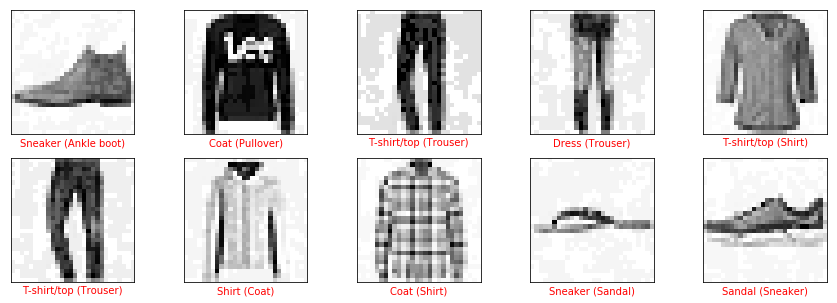

In [11]:
plot_sample_images(model, x_test_adv_images, x_test_labels)

Now here's a plot of the first 10 images and their predictions using the adversarially trained model.



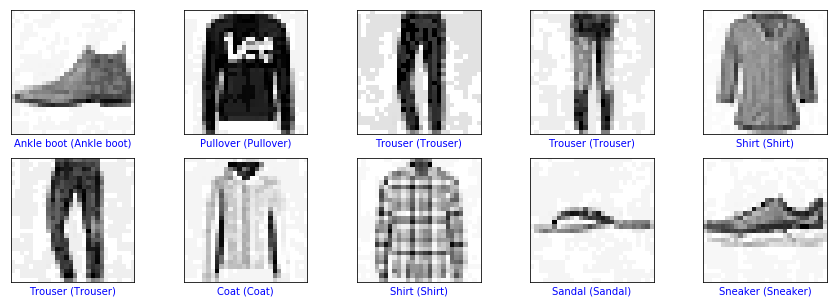

In [12]:
plot_sample_images(model_adv, x_test_adv_images, x_test_labels)

This looks good as the new model is not fooled. 

Unfortunately, this is a poor evaluation. 
Firstly, we’ve only tested the model’s robustness to a specific attack. 
Secondly, for a proper evaluation, we need to assume that the attacker has complete knowledge of the model and its defenses. An attacker with complete knowledge is able to generate their adversarial data directly against the adversarially trained model, so this is the scenario that needs to be evaluated. This is examined in [chapter10/FashionMNIST_adversarial_training_evaluation.ipynb](../chapter10/FashionMNIST_adversarial_training_evaluation.ipynb).

## Save the model if you wish to evaluate later

In [17]:
#model_adv.save('../models/fashionMNIST_advtrain.h5')

## Where next?

Head to 
[chapter10/FashionMNIST_adversarial_training_evaluation.ipynb](../chapter10/FashionMNIST_adversarial_training_evaluation.ipynb) to evaluate the model.